In [1]:
import clip
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
from forgery import *
from torchvision.utils import save_image
import torch.nn as nn
import numpy as np
from types import SimpleNamespace



import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

model = torch.load('res/resnet18_watermark_classifier_full_99.pth', map_location=device)
model = model.to(device)
model.eval()

/home/yw699/anaconda3/envs/forgery-watermark/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yw699/anaconda3/envs/forgery-watermark/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_3000248/3509398222.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [15]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        pred = output.argmax(dim=1).item()
    
    label_map = {0: "Original", 1: "Watermarked"}
    return label_map[pred]



In [16]:
original_path = "/work/forgery/Data/StableSignature/original/img_0001.png"
result = predict_image(original_path)
print(f"Prediction: {result}")

watermarked_path = "/work/forgery/Data/StableSignature/watermarked/img_0001.png"
result = predict_image(watermarked_path)
print(f"Prediction: {result}")

Prediction: Original
Prediction: Watermarked


### show the difference between original and watermark image in the Classifier view

In [6]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        # 去掉最后的分类层，只保留 feature extractor 部分
        self.features = nn.Sequential(*list(model.children())[:-1])  # 去掉 fc 层

    def forward(self, x):
        x = self.features(x)  # [B, 512, 1, 1]
        return x.view(x.size(0), -1)  # flatten to [B, 512]

In [7]:
feature_extractor = ResNetFeatureExtractor(model).to(device)
feature_extractor.eval()
def compare_resnet_feature_distance(img1, img2):
    img1_tensor = transform(img1).unsqueeze(0).to(device)
    img2_tensor = transform(img2).unsqueeze(0).to(device)

    with torch.no_grad():
        feat1 = feature_extractor(img1_tensor)
        feat2 = feature_extractor(img2_tensor)

    # 计算 cosine 和 L2 距离
    cosine_sim = F.cosine_similarity(feat1, feat2).item()
    l2_dist = torch.norm(feat1 - feat2).item()

    print(f"[ResNet18 分类器] Cosine similarity: {cosine_sim:.4f}")
    print(f"[ResNet18 分类器] L2 distance: {l2_dist:.4f}")
    return cosine_sim, l2_dist

In [8]:
img1 = Image.open(original_path).convert("RGB")
img2 = Image.open(watermarked_path).convert("RGB")

compare_resnet_feature_distance(img1, img2)

[ResNet18 分类器] Cosine similarity: 0.9386
[ResNet18 分类器] L2 distance: 26.8856


(0.9386321902275085, 26.88560676574707)

In [9]:
def denormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406], device=t.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=t.device).view(1, 3, 1, 1)
    return torch.clamp(t * std + mean, 0, 1)

For CLIP:

l2_dist:1.3796164989471436 

In [10]:

img1_tensor = transform(img1).unsqueeze(0).to(device)
img2_tensor = transform(img2).unsqueeze(0).to(device)
msg_extractor = torch.jit.load("models/dec_48b_whit.torchscript.pt").to("cuda")
key = '111010110101000001010111010011010100010000100111' 

args = SimpleNamespace(
    r=1,
    lr=0.001,
    epsilon=0.01,
    iteration=100
)

criterion  = nn.CrossEntropyLoss()
bit_acc_groundtruth, bound, success,adv_img,original,acc_list,diff_list =Forgery_no_box_classifier(img1_tensor, key, criterion, msg_extractor,model,args)

save_image(denormalize(adv_img.cpu()), "forged_img.png")
print("🖼️ forged_img.png saved.")

save_image(denormalize(original.cpu()), "original_img.png")
print("🖼️ original_img.png saved.")

iter:0    loss:6.4103  P(cls=1):0.000 watermark_acc:0.562500
iter:1    loss:6.2200  P(cls=1):0.000 watermark_acc:0.562500
iter:2    loss:6.0322  P(cls=1):0.000 watermark_acc:0.562500
iter:3    loss:5.8439  P(cls=1):0.000 watermark_acc:0.562500
iter:4    loss:5.6597  P(cls=1):0.000 watermark_acc:0.562500
iter:5    loss:5.4785  P(cls=1):0.000 watermark_acc:0.562500
iter:6    loss:5.3040  P(cls=1):0.000 watermark_acc:0.562500
iter:7    loss:5.1357  P(cls=1):0.000 watermark_acc:0.562500
iter:8    loss:4.9729  P(cls=1):0.000 watermark_acc:0.562500
iter:9    loss:4.8132  P(cls=1):0.000 watermark_acc:0.562500
iter:10   loss:4.6543  P(cls=1):0.000 watermark_acc:0.562500
iter:11   loss:4.4968  P(cls=1):0.000 watermark_acc:0.562500
iter:12   loss:4.3441  P(cls=1):0.000 watermark_acc:0.562500
iter:13   loss:4.1950  P(cls=1):0.000 watermark_acc:0.562500
iter:14   loss:4.0498  P(cls=1):0.000 watermark_acc:0.562500
iter:15   loss:3.9043  P(cls=1):0.000 watermark_acc:0.562500
iter:16   loss:3.7584  P

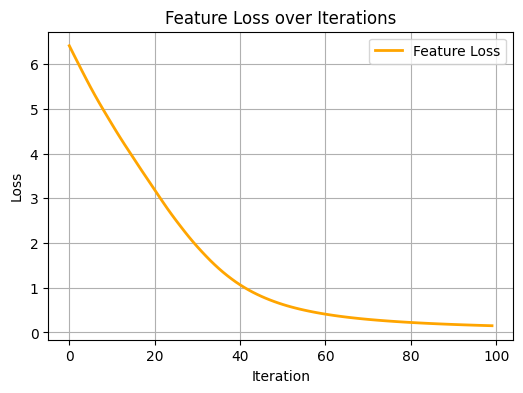

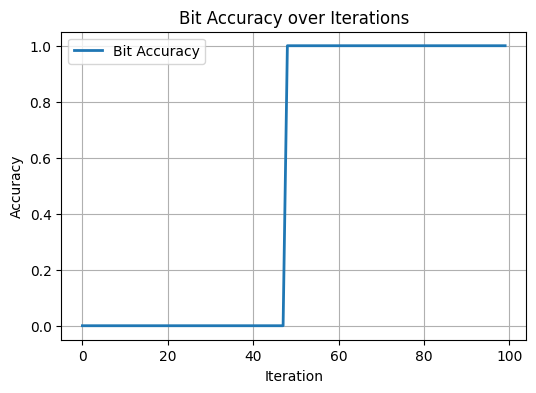

In [11]:
import matplotlib.pyplot as plt
# Feature Loss 
plt.figure(figsize=(6, 4))
plt.plot(diff_list, label="Feature Loss", color='orange', linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Feature Loss over Iterations")
plt.grid(True)
plt.legend()
plt.show()

# Bit Accuracy 
plt.figure(figsize=(6, 4))
plt.plot(acc_list, label="Bit Accuracy", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Bit Accuracy over Iterations")
plt.grid(True)
plt.legend()
plt.show()



In [17]:
from stable_signature_util import *
orig_path = "forged_img.png"
to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  
])

img = to_tensor(Image.open(orig_path)).unsqueeze(0).float()
mes = watermark_decoder(msg_extractor,img)
computer_acc(mes,key)

0.5208333333333333

In [18]:
original_path = "original_img.png"
result = predict_image(original_path)
print(f"Prediction: {result}")

forged_path = "forged_img.png"
result = predict_image(watermarked_path)
print(f"Prediction: {result}")

Prediction: Original
Prediction: Watermarked
